In [64]:
import ast
from collections import Counter

from imblearn.under_sampling import RandomUnderSampler
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, MiniBatchKMeans

In [80]:
# Set the number of neurons to the same number as the loaded model
som_neurons = (44, 44)
model_path = '../models/AgglomerativeClustering_training_lr_0.001_sigma_1.5.p'
ClusterClass = AgglomerativeClustering
# ClusterClass = MiniBatchKMeans

# Set this to LogNorm() if there is no clear clustering
HeatmapColorNormClass = lambda: None
# HeatmapColorNormClass = LogNorm

rng = np.random.default_rng()

## Data
Select a subset of tracks from some genres, and under sample the genres
to the size of the smallest genre.

In [66]:
genres = ["rock",
          "classical",
          "latin",
          "pop",
          "jazz",
          "soul",
          "classic bollywood",
          "rap",
          "folk",
          "funk",
          "opera"]
tracks = pd.read_csv('../data/tracks_with_genres.csv')
tracks['genres'] = tracks['genres'].apply(ast.literal_eval)
tracks = tracks.explode('genres')
tracks.rename(columns={'genres': 'genre'}, inplace=True)
tracks_subset = tracks[tracks['genre'].isin(genres)]

rus = RandomUnderSampler(random_state=1)
X, y = rus.fit_resample(tracks_subset, tracks_subset['genre'])

tracks_genres = y.astype('category')

print(f'In total, there are {y.shape[0]} tracks in the dataset used.')

In total, there are 84084 tracks in the dataset used.


Convert the pandas dataframe to a matrix of numerical values, normalize the values column wise and shuffle the rows.

In [67]:
features = ['acousticness', 'instrumentalness', 'loudness', 'energy', 'danceability', 'valence']
tracks_values = X[features].values
tracks_values = (tracks_values - tracks_values.mean(axis=0))/tracks_values.std(axis=0)
rng.shuffle(tracks_values, axis=0)

In [68]:
# Load model
with open(model_path, 'rb') as model_file:
    som = pickle.load(model_file)

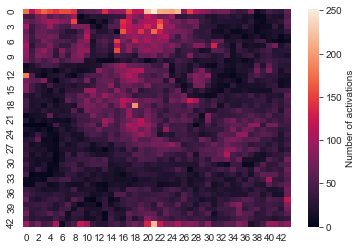

In [69]:
neuron_activations = som.activation_response(tracks_values)

sns.set_style('white')
heatmap = sns.heatmap(neuron_activations, cbar_kws={'label': 'Number of activations'},
                      norm=HeatmapColorNormClass())
#plt.axis('off')
plt.show()
heatmap.get_figure().savefig('../figures/neurons_heatmap.png')

Display the distance map.

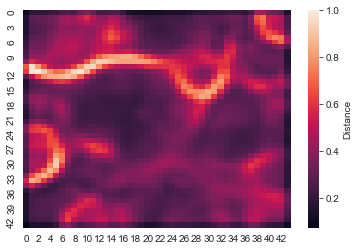

In [74]:
sns.set_style('white')
heatmap = sns.heatmap(som.distance_map(), cbar_kws={'label': 'Distance'},
                      norm=HeatmapColorNormClass())
#plt.axis('off')
plt.show()
heatmap.get_figure().savefig('../figures/neurons_distance_map.png')

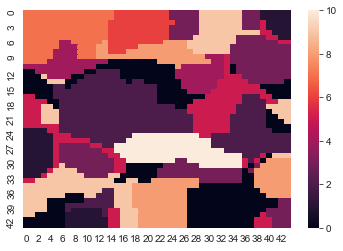

In [75]:
cluster = ClusterClass(n_clusters=len(genres))
som_weights = som.get_weights()
labels = cluster.fit_predict(
    som_weights.reshape(som_neurons[0]*som_neurons[1], len(features))
)

labels_matrix = labels.reshape(som_neurons[0], som_neurons[1])
sns.heatmap(labels_matrix)
plt.show()

In [76]:
labels_map = som.labels_map(tracks_values, tracks_genres)
labels_classified_as_genre = [Counter() for i in range(len(genres))]

for neuron in range(len(labels)):
    y, x = neuron//som_neurons[1], neuron%som_neurons[1]
    label = labels[neuron]
    counter = labels_map[(y, x)]

    if counter:
        labels_classified_as_genre[label] += counter

for label in labels_classified_as_genre:
    print(label)

Counter({'classic bollywood': 1169, 'funk': 1153, 'classical': 1145, 'jazz': 1123, 'rock': 1118, 'latin': 1114, 'pop': 1108, 'soul': 1103, 'folk': 1091, 'opera': 1090, 'rap': 1088})
Counter({'jazz': 251, 'rap': 227, 'pop': 222, 'folk': 219, 'latin': 214, 'rock': 214, 'soul': 209, 'classic bollywood': 208, 'funk': 201, 'opera': 198, 'classical': 195})
Counter({'classic bollywood': 1649, 'rock': 1649, 'jazz': 1647, 'rap': 1645, 'pop': 1626, 'latin': 1622, 'classical': 1616, 'soul': 1615, 'folk': 1590, 'opera': 1581, 'funk': 1558})
Counter({'soul': 840, 'latin': 804, 'funk': 794, 'classic bollywood': 783, 'folk': 776, 'rock': 763, 'pop': 762, 'classical': 750, 'rap': 750, 'opera': 749, 'jazz': 714})
Counter({'folk': 324, 'classic bollywood': 323, 'latin': 310, 'pop': 310, 'classical': 302, 'rock': 301, 'opera': 279, 'rap': 279, 'funk': 278, 'jazz': 276, 'soul': 276})
Counter({'latin': 412, 'funk': 406, 'rap': 396, 'classical': 394, 'soul': 391, 'opera': 389, 'pop': 388, 'jazz': 380, 'rock

Songs per genre and cluster


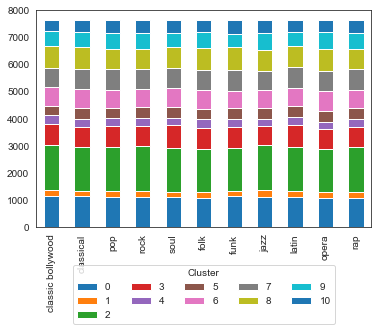

Songs per genre and cluster


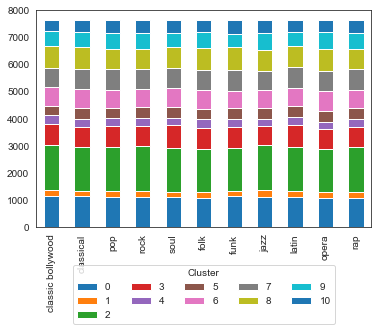

In [77]:
print("Songs per genre and cluster")
classifications = pd.DataFrame(labels_classified_as_genre)
classifications.T.plot.bar(stacked=True)
plt.legend(title='Cluster', loc='upper center', ncol=len(genres)//2,
           bbox_to_anchor=(0.5, -0.15))
plt.show()